# ETL Project
Madison Massie

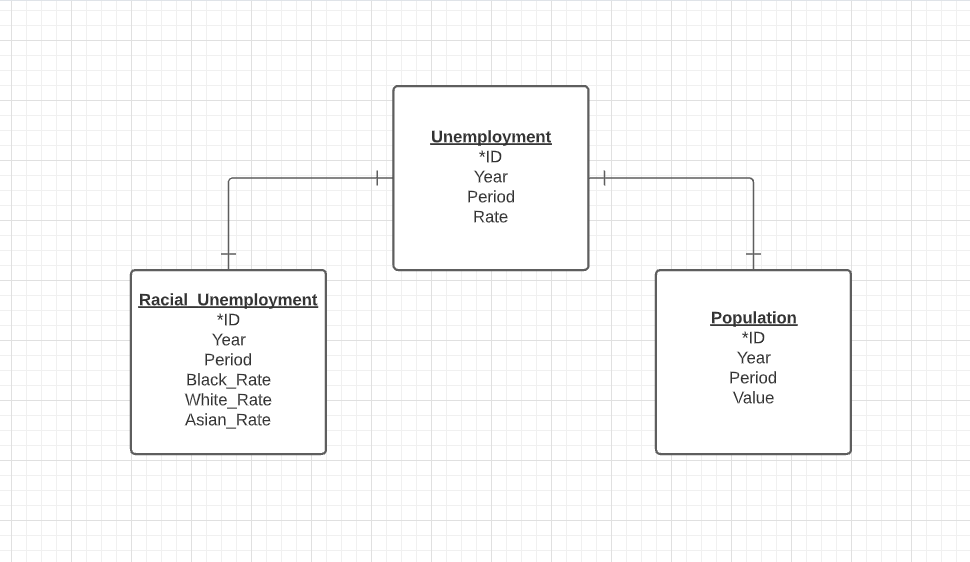

In [1]:
#Import modules
import psycopg2
import pandas as pd
import numpy as np

#Import password for postgres
from passwords import password

In [2]:
#Read in data from CSV files (not including Series ID)
unemployment = pd.read_csv('Initial/unemployment.csv', usecols=[1, 2, 3, 4])
population = pd.read_csv('Initial/population.csv', usecols=[1, 2, 3, 4])
black_unemployment = pd.read_csv('Initial/black_unemployment.csv', usecols=[1, 2, 3, 4])
white_unemployment = pd.read_csv('Initial/white_unemployment.csv', usecols=[1, 2, 3, 4])
asian_unemployment = pd.read_csv('Initial/asian_unemployment.csv', usecols=[1, 2, 3, 4])

In [3]:
unemployment.head()

,Year,Period,Label,Value
0,2016,M01,2016 Jan,5.3
1,2016,M02,2016 Feb,5.2
2,2016,M03,2016 Mar,5.1
3,2016,M04,2016 Apr,4.7
4,2016,M05,2016 May,4.5


### Preprocess Data

In [4]:
#Update Period column so it just has the month as an int
unemployment['Period'] = unemployment['Period'].str.replace('M', '')
population['Period'] = population['Period'].str.replace('M', '')
black_unemployment['Period'] = black_unemployment['Period'].str.replace('M', '')
white_unemployment['Period'] = white_unemployment['Period'].str.replace('M', '')
asian_unemployment['Period'] = asian_unemployment['Period'].str.replace('M', '')

In [5]:
#Check if Period column has been updated
population.head()

,Year,Period,Label,Value
0,2016,01,2016 Jan,252397
1,2016,02,2016 Feb,252577
2,2016,03,2016 Mar,252768
3,2016,04,2016 Apr,252969
4,2016,05,2016 May,253174


In [6]:
#Check the length of all the dataframes to make sure they're the same size
print(len(unemployment))
print(len(population))
print(len(black_unemployment))
print(len(white_unemployment))
print(len(asian_unemployment))

72
72
72
72
72


In [7]:
#Check for null values
unemployment.isnull().sum()

Year      0
Period    0
Label     0
Value     0
dtype: int64

In [8]:
#Check for null values
population.isnull().sum()

Year      0
Period    0
Label     0
Value     0
dtype: int64

In [9]:
#Check for null values
black_unemployment.isnull().sum()

Year      0
Period    0
Label     0
Value     0
dtype: int64

In [10]:
#Check for null values
asian_unemployment.isnull().sum()

Year      0
Period    0
Label     0
Value     0
dtype: int64

In [11]:
#Check for null values
white_unemployment.isnull().sum()

Year      0
Period    0
Label     0
Value     0
dtype: int64

In [12]:
#Reorder the dataframes so that label is the first column
unemployment = unemployment.reindex(columns=['Label', 'Year', 'Period', 'Value'])
population = population.reindex(columns=['Label', 'Year', 'Period', 'Value'])
black_unemployment = black_unemployment.reindex(columns=['Label', 'Year', 'Period', 'Value'])
white_unemployment = white_unemployment.reindex(columns=['Label', 'Year', 'Period', 'Value'])
asian_unemployment = asian_unemployment.reindex(columns=['Label', 'Year', 'Period', 'Value'])

In [13]:
#Check that datframe has been updated
black_unemployment.head()

,Label,Year,Period,Value
0,2016 Jan,2016,01,9.1
1,2016 Feb,2016,02,8.9
2,2016 Mar,2016,03,9.0
3,2016 Apr,2016,04,8.2
4,2016 May,2016,05,8.0


In [14]:
#Merge the black_unemployment and white_unemployment dataframes into one racial_unemployment dataframe
racial_unemployment = black_unemployment.merge(right=white_unemployment, how='left', on='Label')
racial_unemployment.head()

,Label,Year_x,Period_x,Value_x,Year_y,Period_y,Value_y
0,2016 Jan,2016,01,9.1,2016,01,4.7
1,2016 Feb,2016,02,8.9,2016,02,4.6
2,2016 Mar,2016,03,9.0,2016,03,4.4
3,2016 Apr,2016,04,8.2,2016,04,4.1
4,2016 May,2016,05,8.0,2016,05,3.9


In [15]:
#Drop duplicate columns and rename remaining columns
racial_unemployment.drop(columns=['Year_y', 'Period_y'], inplace=True)
racial_unemployment = racial_unemployment.rename(columns={'Year_x': 'Year', 'Period_x': 'Period', 'Value_x': 'Black', 'Value_y': 'White'})
racial_unemployment.head()

,Label,Year,Period,Black,White
0,2016 Jan,2016,01,9.1,4.7
1,2016 Feb,2016,02,8.9,4.6
2,2016 Mar,2016,03,9.0,4.4
3,2016 Apr,2016,04,8.2,4.1
4,2016 May,2016,05,8.0,3.9


In [16]:
#Merge the racial unemployment dataframe with the asian unemployment dataframe
racial_unemployment = racial_unemployment.merge(right=asian_unemployment, how='left', on='Label')
racial_unemployment.head()

,Label,Year_x,Period_x,Black,White,Year_y,Period_y,Value
0,2016 Jan,2016,01,9.1,4.7,2016,01,3.7
1,2016 Feb,2016,02,8.9,4.6,2016,02,3.9
2,2016 Mar,2016,03,9.0,4.4,2016,03,3.9
3,2016 Apr,2016,04,8.2,4.1,2016,04,3.6
4,2016 May,2016,05,8.0,3.9,2016,05,3.9


In [17]:
#Drop duplicate columns and rename remaining columns
racial_unemployment.drop(columns=['Year_y', 'Period_y'], inplace=True)
racial_unemployment = racial_unemployment.rename(columns={'Year_x': 'Year', 'Period_x': 'Period', 'Value': 'Asian'})
racial_unemployment.head()

,Label,Year,Period,Black,White,Asian
0,2016 Jan,2016,01,9.1,4.7,3.7
1,2016 Feb,2016,02,8.9,4.6,3.9
2,2016 Mar,2016,03,9.0,4.4,3.9
3,2016 Apr,2016,04,8.2,4.1,3.6
4,2016 May,2016,05,8.0,3.9,3.9


In [18]:
#Create new csv files
unemployment.to_csv('New/unemployment.csv', index=False)
population.to_csv('New/population.csv', index=False)
racial_unemployment.to_csv('New/racial_unemployment.csv', index=False)

### Create SQL Tables

In [19]:
#Open a connection to postgres and create a connection object
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password=password)
#Create a cursor object to execute commands
cur = conn.cursor()

#Use the cursor object to drop the existing table if it exists and create a table for Unemployment
cur.execute('DROP TABLE IF EXISTS Unemployment')
cur.execute('''
    CREATE TABLE Unemployment(
    ID text PRIMARY KEY,
    YEAR integer,
    MONTH integer,
    RATE float)
''')

#Commit changes 
conn.commit()

In [20]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Open the created csv file
with open('New/unemployment.csv', 'r') as i:
    #Skip header row
    next(i) 
    
    #Call the created unemployment table and copy data from csv file into table
    cur.copy_from(i, 'unemployment', sep=',', null='')

#Commit changes 
conn.commit()

In [21]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Use the cursor object to drop the existing table if it exists and create a table for Population
cur.execute('DROP TABLE IF EXISTS Population')
cur.execute('''
    CREATE TABLE Population(
    ID text PRIMARY KEY,
    YEAR integer,
    MONTH integer,
    VALUE float)
''')

#Commit changes 
conn.commit()

In [22]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Open the created csv file
with open('New/population.csv', 'r') as i:
    #Skip header row
    next(i) 
    
    #Call the created population table and copy data from csv file into table
    cur.copy_from(i, 'population', sep=',', null='')

#Commit changes 
conn.commit()

In [23]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Use the cursor object to drop the existing table if it exists and create a table for Racial_Unemployment
cur.execute('DROP TABLE IF EXISTS Racial_Unemployment')
cur.execute('''
    CREATE TABLE Racial_Unemployment(
    ID text PRIMARY KEY,
    YEAR integer,
    MONTH integer,
    BLACK_RATE float,
    WHITE_RATE float,
    ASIAN_RATE float)
''')

#Commit changes 
conn.commit()

In [24]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Open the created csv file
with open('New/racial_unemployment.csv', 'r') as i:
    #Skip header row
    next(i) 
    
    #Call the created racial_unemployment table and copy data from csv file into table
    cur.copy_from(i, 'racial_unemployment', sep=',', null='')

#Commit changes 
conn.commit()
#Close connection
conn.close()

## Queries

1. What was the unemployment rate at the max population? - join
2. How did the average population compare to the average unemployment rate? - join
3. Which race had the highest unemployment rate?
4. How did the average unemployment rate compare with the average unemployment by race? - join
5. Which month had the highest unemployment rate?
6. What month had the highest average unemployment rate?

### 1. What was the unemployment rate at the max population? - join

In [25]:
#Open a connection to postgres and create a connection object
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password=password)

#This query joins the population and unemployment tables using id
#It selects the population id, the max population value, and the unemployment rate
#It groups the rows by population id and unemployment rate 
#It then orders the results by max population in descending order
query = '''
    SELECT p.id, MAX(p.value) as max_pop, u.rate
    FROM POPULATION p
    LEFT JOIN UNEMPLOYMENT u ON p.id = u.id
    GROUP BY p.id, u.rate
    ORDER BY max_pop DESC LIMIT 1;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,id,max_pop,rate
0,2021 Dec,262136.0,3.7


### 2. How did the average population compare to the average unemployment rate? - join

In [26]:
#This query joins the population and unemployment tables using id
#It selects the year, the average population, and the average unemployment rate
#It groups and orders the results by year to find the yearly average population and unemployment rate
query = '''
    SELECT p.year, ROUND(AVG(p.value::numeric)) as avg_pop,
        ROUND(AVG(u.rate::numeric), 2) as avg_unemployment
    FROM population p
    LEFT JOIN unemployment u ON p.id = u.id
    GROUP BY p.year
    ORDER BY p.year;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,year,avg_pop,avg_unemployment
0,2016,253538.0,4.87
1,2017,255079.0,4.35
2,2018,257791.0,3.90
3,2019,259175.0,3.67
4,2020,260329.0,8.09
5,2021,261445.0,5.37


### 3. Which race had the highest unemployment rate?

In [27]:
#This query selects the year and the max unemployment rate for each race from the racial_unemployment table
#It then groups the results by year
query = '''
    SELECT year, MAX(black_rate) as max_black, MAX(white_rate) as max_white, MAX(asian_rate) as max_asian
    FROM racial_unemployment
    GROUP BY year;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,year,max_black,max_white,max_asian
0,2017,8.3,4.7,4.0
1,2016,9.1,4.7,4.2
2,2018,8.0,4.0,3.5
3,2020,16.6,13.8,14.8
4,2019,7.4,4.0,3.2
5,2021,10.2,6.2,6.8


### 4. How did the average unemployment rate compare with the average unemployment by race? - join

In [28]:
#Create a cursor object to execute commands
cur = conn.cursor()

#Use the cursor object to execute a query:
    #This query joins the unemployment and racial_unemployment tables using id
    #It then selects the year and the rounded average unemployment rate for each race and overall
    #It then groups and orders the results by year
query = '''
    SELECT u.year, ROUND(AVG(u.rate::numeric), 2) as avg_unemployment,
        ROUND(AVG(r.black_rate::numeric), 2) as avg_black_unemployment,
        ROUND(AVG(r.white_rate::numeric), 2) as avg_white_unemployment, 
        ROUND(AVG(r.asian_rate::numeric), 2) as avg_asian_unemployment
    FROM unemployment u
    LEFT JOIN racial_unemployment r ON u.id = r.id
    GROUP BY u.year
    ORDER BY u.year;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,year,avg_unemployment,avg_black_unemployment,avg_white_unemployment,avg_asian_unemployment
0,2016,4.87,8.43,4.28,3.64
1,2017,4.35,7.47,3.83,3.39
2,2018,3.90,6.48,3.45,2.99
3,2019,3.67,6.07,3.30,2.68
4,2020,8.09,11.48,7.34,8.71
5,2021,5.37,8.58,4.71,5.03


### 5. What month has the highest unemployment rate?

In [29]:
#This query selects the period (month) and the max unemployment rate
#It then groups the results by month and orders the results by max unemployment rate in decending order 
query = '''
    SELECT month, MAX(rate)
    FROM UNEMPLOYMENT
    GROUP BY month
    ORDER BY MAX(rate) DESC LIMIT 1;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,month,max
0,4,14.4


### 6. What month had the highest average unemployment rate?

In [30]:
#This query selects the period (month) and the rounded average unemployment rate
#It then groups the results by month and orders the results by avg unemployment rate in decending order 
query = '''
    SELECT month, ROUND(AVG(rate)::numeric, 2) as avg_unemployment
    FROM UNEMPLOYMENT
    GROUP BY month
    ORDER BY AVG(rate) DESC LIMIT 1;
'''

#Reads sql query into a dataframe
pd.read_sql(query, conn)

,month,avg_unemployment
0,4,5.98


In [31]:
#Close connection
conn.close()